# Set up

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Convolutional Layers

## Implementing Convolutional Layers with Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70x120 images.

In [2]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

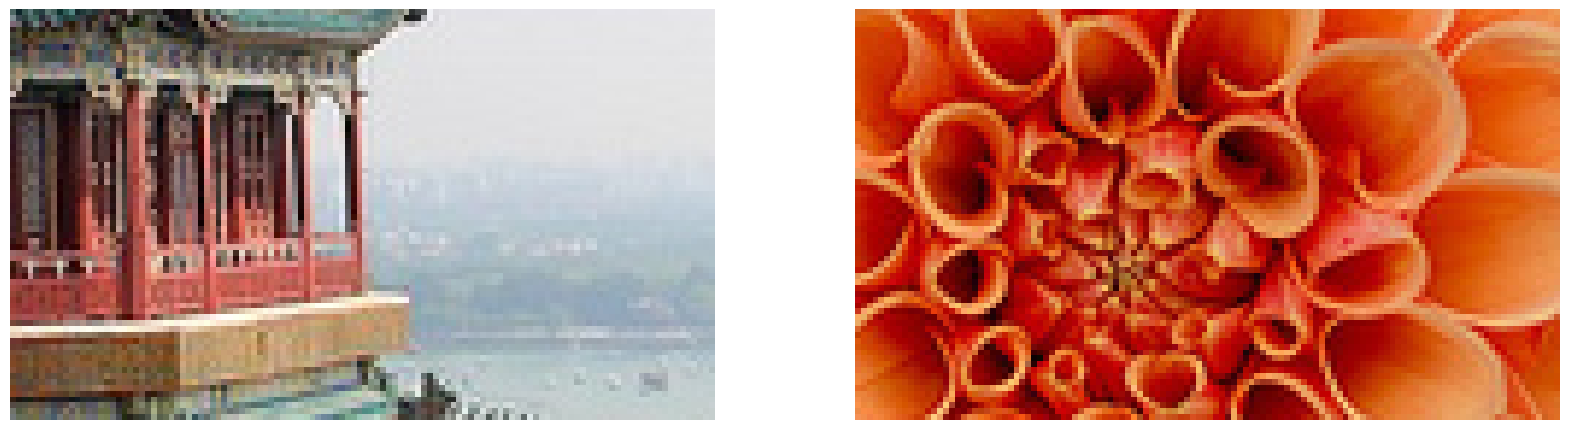

In [3]:
plt.figure(figsize=(20, 10))
for img_idx in [0, 1]:
    plt.subplot(1, 2, img_idx + 1)
    plt.imshow(images[img_idx])
    plt.axis("off")
plt.show()

In [4]:
images.shape

TensorShape([2, 70, 120, 3])

In [5]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
filter_maps = conv_layer(images)

In [6]:
filter_maps.shape

TensorShape([2, 64, 114, 32])

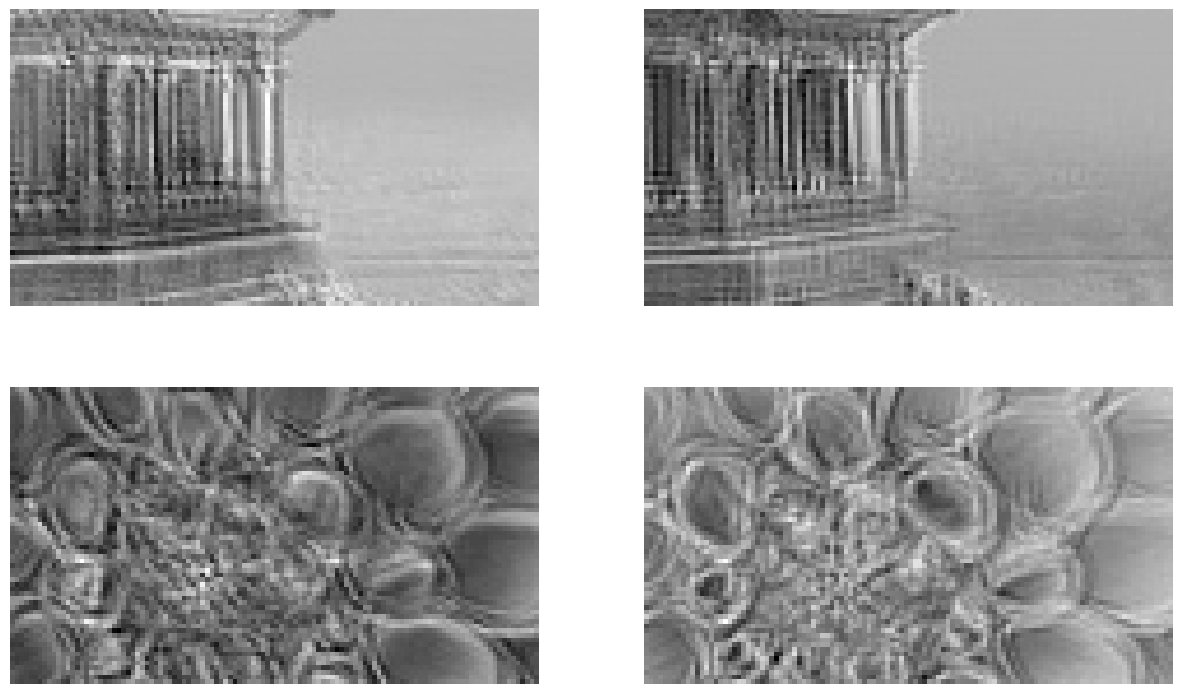

In [7]:
# Extra code displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for filter_map_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + filter_map_idx + 1)
        plt.imshow(filter_maps[image_idx, :, :, filter_map_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
filter_maps = conv_layer(images)
filter_maps.shape

TensorShape([2, 70, 120, 32])

In [9]:
# extra code - shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(
    filters=32, kernel_size=7, padding="same", strides=2
)
filter_maps = conv_layer(images)
filter_maps.shape

TensorShape([2, 35, 60, 32])

In [10]:
# extra code - this utility function can be useful to compute the size of the feature maps output by a convolutional layer. It also returns the number of ignored rows or columns if padding="valid", or the number of zero-padded rows or columns if padding="same".
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding == "valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

Now let's look at the weights.

In [11]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [12]:
biases.shape

(32,)

In [13]:
# Extra code shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
filter_maps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Now we manually create two filters full of zeros, expect for a vertical line of 1s in the first filter, and a horizontal one in the second filter. The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice, you will never need to create filters manually, since the convolutional layers will learn them automatically.

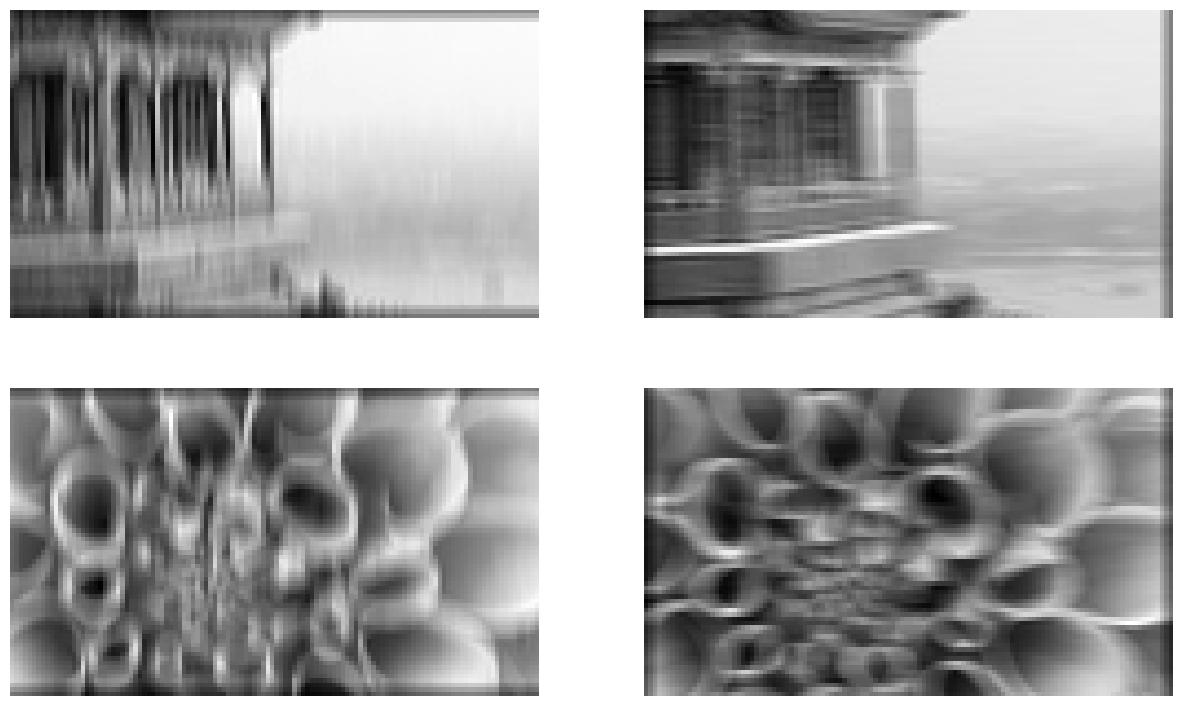

In [14]:
# Extra code shows how to manually create two filters to get images similar to those in note.md.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
filter_maps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for filter_map_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + filter_map_idx + 1)
        plt.imshow(filter_maps[image_idx, :, :, filter_map_idx], cmap="gray")
        plt.axis("off")
plt.show()

- Notice that dark lines at the bottom and top of the left images, and at the left and right of the right images. Recall that they didn't appear in the previous figure, then why they appear in this case?
- These are artifacts due to the fact that we use zero padding in this case.
- Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and the bottom of images.
- Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and the right of images.

# Pooling Layers

## Implementing Pooling Layers with Keras

**Max pooling**

In [15]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [16]:
output = max_pool(images)

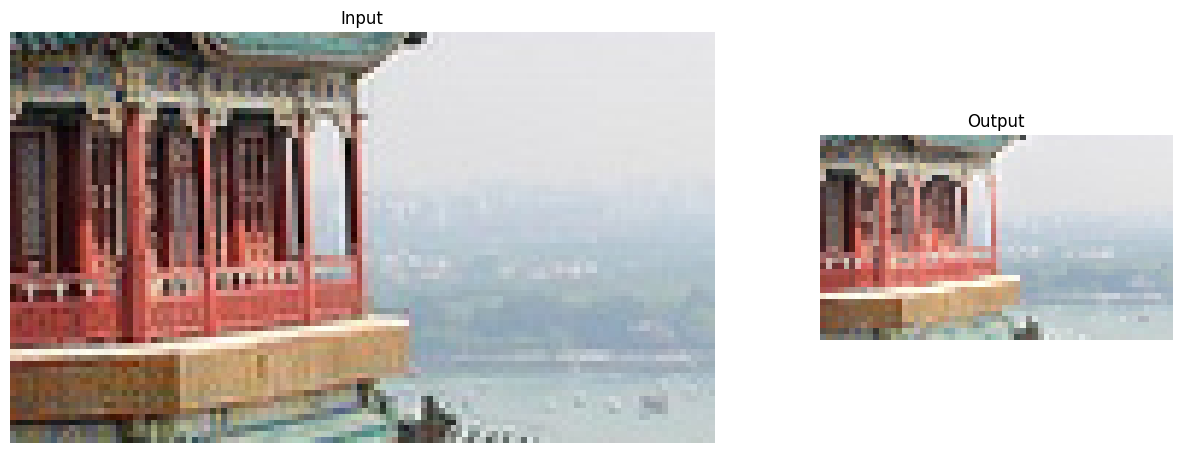

In [17]:
import matplotlib as mpl

fig = plt.figure(figsize=(15, 10))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

**Depth-wise max pooling**

In [18]:
# Extra code shows how to use the max_pool() operation; only works on the CPU
np.random.seed(42)
filter_maps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(
        filter_maps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"
    )

output.shape

TensorShape([2, 70, 120, 20])

In [19]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [20]:
# Extra code shows that this custom layer gives th same result as max_pool()
np.allclose(DepthPool(pool_size=3)(filter_maps), output)

True

(-0.5, 119.5, 69.5, -0.5)

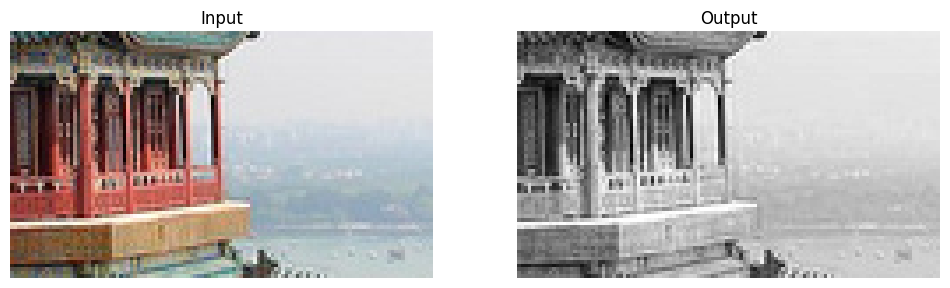

In [21]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(images[0])
plt.title("Input")
plt.axis("off")

plt.subplot(122)
plt.imshow(depth_output[0, ..., 0], cmap="gray")
plt.title("Output")
plt.axis("off")

**Global Average Pooling**

In [22]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [23]:
global_avg_pool = tf.keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [24]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

# CNN Architectures

In [25]:
(X_train_full, y_train_full), (X_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data()
)
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [26]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)
model = tf.keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_predict = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 35s 10ms/step - loss: 0.7826 - accuracy: 0.7225 - val_loss: 0.3936 - val_accuracy: 0.8654
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4562 - accuracy: 0.8442 - val_loss: 0.3416 - val_accuracy: 0.8766
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3749 - accuracy: 0.8731 - val_loss: 0.3065 - val_accuracy: 0.8906
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3307 - accuracy: 0.8886 - val_loss: 0.2602 - val_accuracy: 0.9022
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3018 - accuracy: 0.8977 - val_loss: 0.2599 - val_accuracy: 0.9058
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2782 - accuracy: 0.9061 - val_loss: 0.2741 - val_accuracy: 0.8992
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2626 - accuracy: 0.9104 - val_loss: 0.2727 - val_

# Implementing a ResNet-34 CNN Using Keras

In [28]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    strides=1,
    padding="same",
    kernel_initializer="he_normal",
    use_bias=False,
)


class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters=filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters=filters),
            tf.keras.layers.BatchNormalization(),
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters=filters, strides=strides, kernel_size=1),
                tf.keras.layers.BatchNormalization(),
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [29]:
model = tf.keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
    ]
)
prev_filters = 64
for filter in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    stride = 1 if filter == prev_filters else 2
    model.add(ResidualUnit(filters=filter, strides=stride))
    prev_filters = filter

model.add(tf.keras.layers.AvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Using Pretrained Models from Keras

In [30]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 1s 0us/step


In [31]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(
    height=224, width=224, crop_to_aspect_ratio=True
)(images)

In [32]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [33]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 2s 2s/step


(2, 1000)

In [34]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"\t {class_id} - {name:12s}  {y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
Image #0
	 n03877845 - palace        54.69%
	 n03781244 - monastery     24.71%
	 n02825657 - bell_cote     18.55%
Image #1
	 n04522168 - vase          32.67%
	 n11939491 - daisy         17.82%
	 n03530642 - honeycomb     12.04%


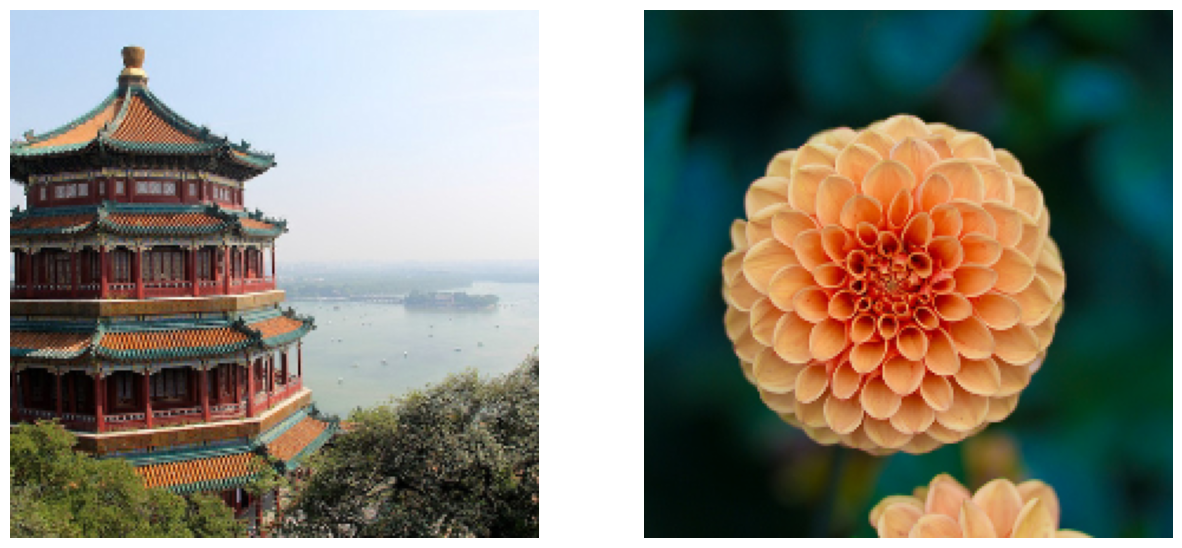

In [35]:
# Extra code displays the cropped and resized images

plt.figure(figsize=(15, 9))
for idx in [0, 1]:
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")
plt.show()

# Pretrained Models for Transfer Learning

In [36]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [37]:
dataset_size

3670

In [38]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [39]:
n_classes

5

In [40]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
)

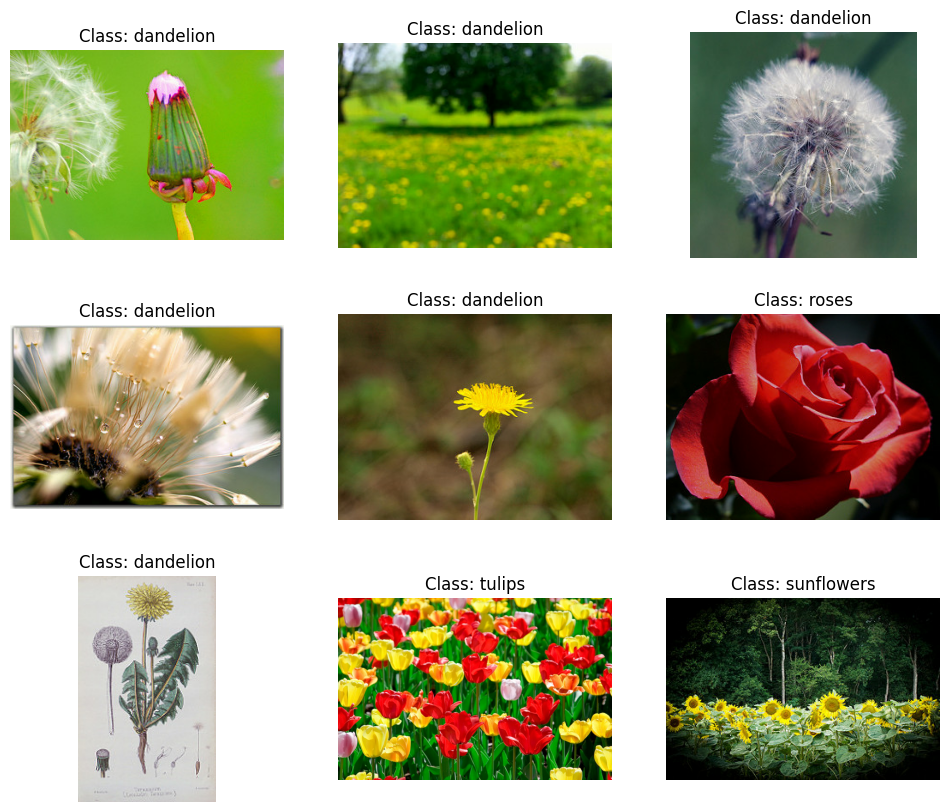

In [41]:
# Extra code displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")
plt.show()

- All three datasets contain individual images.
- We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this.
- We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model.
- Lastly, we'll also add shuffling and prefetching to the training dataset.

In [42]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
        tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input),
    ]
)
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all $224 \times 224$ now, with values ranging form -1 to 1.

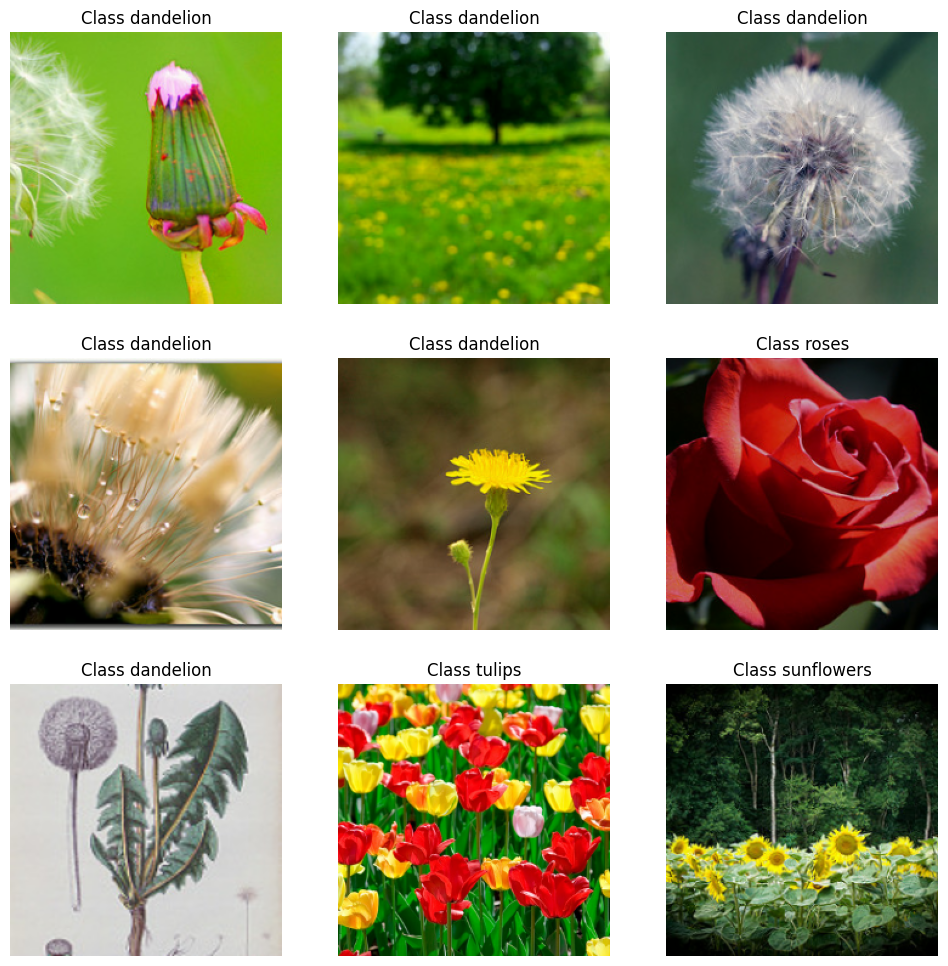

In [43]:
# Extra code displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0-1 for imshow()
        plt.title(f"Class {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

In [44]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
        tf.keras.layers.RandomRotation(factor=0.05, seed=42),
        tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    ]
)

Try running the following code cell multiple times to see different data augmentations.

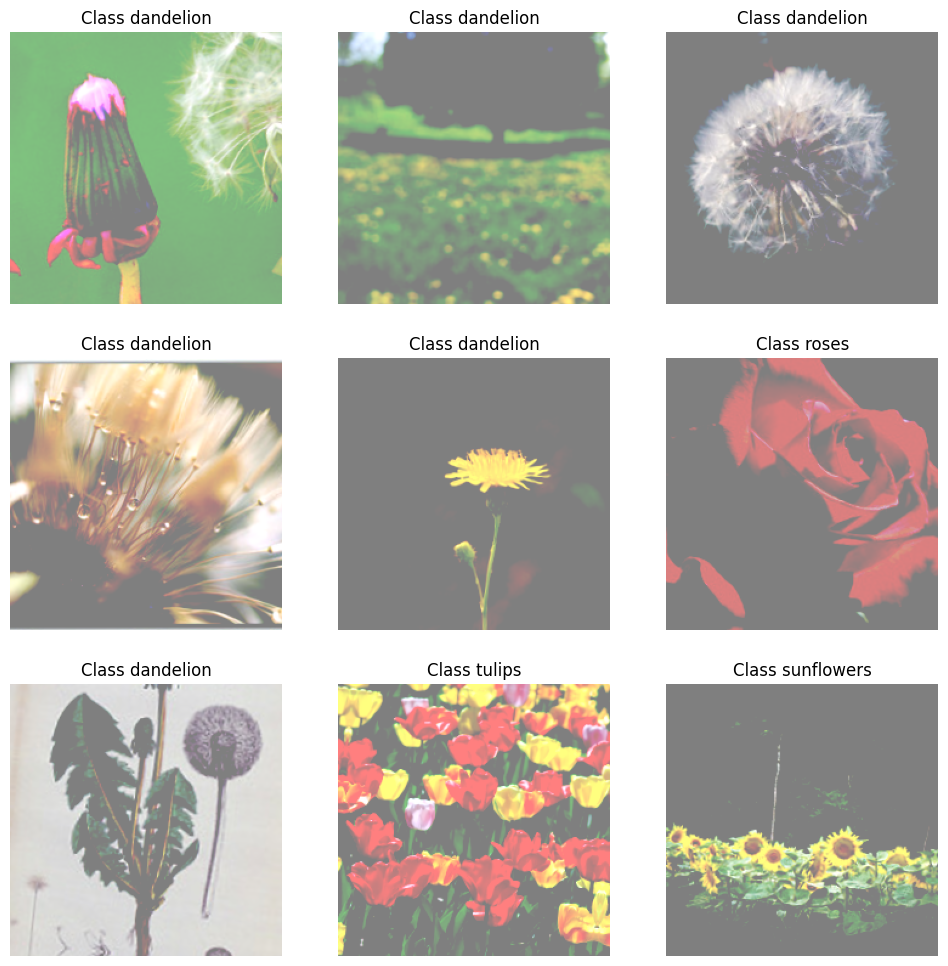

In [50]:
# Extra code displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

Now we load the pretrained model, without its top layers, and replace them with out own, for the flower classification task.

In [53]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet", include_top=False
)
avg = tf.keras.layers.GlobalAvgPool2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [54]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed.

In [55]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 28s 224ms/step - loss: 0.7214 - accuracy: 0.8136 - val_loss: 0.8195 - val_accuracy: 0.8258
Epoch 2/3
86/86 [==============================] - 16s 172ms/step - loss: 0.3330 - accuracy: 0.9092 - val_loss: 0.6059 - val_accuracy: 0.8403
Epoch 3/3
86/86 [==============================] - 16s 177ms/step - loss: 0.1769 - accuracy: 0.9382 - val_loss: 0.7221 - val_accuracy: 0.8475


In [57]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_2                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate.

In [58]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 43s 370ms/step - loss: 0.2921 - accuracy: 0.9095 - val_loss: 0.4229 - val_accuracy: 0.8748
Epoch 2/10
86/86 [==============================] - 28s 320ms/step - loss: 0.0343 - accuracy: 0.9873 - val_loss: 0.3650 - val_accuracy: 0.9074
Epoch 3/10
86/86 [==============================] - 28s 322ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.3701 - val_accuracy: 0.9093
Epoch 4/10
86/86 [==============================] - 29s 325ms/step - loss: 0.0112 - accuracy: 0.9956 - val_loss: 0.3740 - val_accuracy: 0.9056
Epoch 5/10
86/86 [==============================] - 29s 323ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.3677 - val_accuracy: 0.9074
Epoch 6/10
86/86 [==============================] - 28s 322ms/step - loss: 0.0040 - accuracy: 0.9982 - val_loss: 0.4226 - val_accuracy: 0.8929
Epoch 7/10
86/86 [==============================] - 28s 319ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.3863 - val_accuracy: 0.9093